In [28]:
!pip install rembg==2.0.56

In [29]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from rembg import new_session, remove

from skimage.feature import hog
from sklearn.metrics.pairwise import cosine_similarity

In [30]:
class ImageModel:
    def __init__(self, rgb_img, mask_img, cropped_mask=None, cropped_feature=None, key_contour=None):
        self.rgb_img = rgb_img                 # Original Img (RGB)
        self.mask_img = mask_img               # Orignal Img Mask (Binary)
        self.cropped_mask = cropped_mask       # Cropped Mask (Rotated + Binary)
        self.cropped_feature = cropped_feature # Cropped Feature (Rotated + Grayscale)
        self.key_contour = key_contour         # Key Contour

In [31]:
INPUT_PATH = '/kaggle/input/key-images/'

filenames = [file for file in os.listdir(INPUT_PATH) if file[0].isdigit()]
filenames.sort()

filepaths = [os.path.join(INPUT_PATH, file) for file in filenames]

images = [Image.open(path) for path in filepaths]
        
print(f"Number of images loaded: {len(images)}")

Number of images loaded: 19


# Pipeline

In [32]:
def fix_image_size(image):
    PADDING = 12
    
    # Get the original image dimensions
    original_height, original_width = image.shape[:2]

    dimension = max(original_height, original_width)

    # Create a blank canvas of the desired size
    canvas = np.zeros((dimension, dimension), dtype=np.uint8)

    # Calculate the offset to center the image on the canvas
    offset_x = (canvas.shape[1] - image.shape[1]) // 2
    offset_y = (canvas.shape[0] - image.shape[0]) // 2

    # Paste the resized image onto the canvas
    canvas[offset_y:offset_y+image.shape[0], offset_x:offset_x+image.shape[1]] = image

    return canvas


def resize_grayscale_image_to_256x256(image):
    WIDTH = 232
    HEIGHT = 232
    PADDING = 12
    
    DIMENSION = (WIDTH,HEIGHT,PADDING)

    return resize_grayscale_image(image, DIMENSION)


def resize_grayscale_image(image, dimension):
    WIDTH, HEIGHT, PADDING = dimension
    
    # Get the original image dimensions
    original_height, original_width = image.shape[:2]

    # Calculate the scaling factor for both dimensions
    scale_x = WIDTH / original_width
    scale_y = HEIGHT / original_height

    # Choose the smaller scaling factor to maintain aspect ratio
    scale = min(scale_x, scale_y)

    # Resize the image using the calculated scaling factor
    resized_image = cv2.resize(image, None, fx=scale, fy=scale)

    # Create a blank canvas of the desired size
    canvas = np.zeros((HEIGHT + 2*PADDING, WIDTH + 2*PADDING), dtype=np.uint8)

    # Calculate the offset to center the resized image on the canvas
    offset_x = (canvas.shape[1] - resized_image.shape[1]) // 2
    offset_y = (canvas.shape[0] - resized_image.shape[0]) // 2

    # Paste the resized image onto the canvas
    canvas[offset_y:offset_y+resized_image.shape[0], offset_x:offset_x+resized_image.shape[1]] = resized_image
    
    return canvas


def is_ellipse_center_below_lower_half(center, image_shape):
    center_x, center_y = center
    image_width, image_height = image_shape
    return True if (center_y > image_height / 2) else False


def get_rotation_angle(is_below, current_angle):
    new_angle = 0
    if current_angle < 90:
        new_angle = 90 + current_angle
    elif current_angle > 90 and current_angle < 180:
        new_angle = current_angle - 90
    
    return (new_angle + 180) if is_below else (new_angle + 180)

def image_processing_pipeline(image_path):
    # 1. Read img as RGB
    rgb_img = np.array(image_path)

    # 2. Convert RGB to Grayscale and create an empty img of same dimension
    grayscale_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2GRAY)
    empty_img = np.zeros_like(grayscale_img, dtype=np.uint8)

    # 3. Convert rgb to mask
    grayscale_mask = remove_bg(rgb_img, only_mask=True)

    # 4. Convert masked image to binary mask
    grayscale_mask = np.array(grayscale_mask)
    _, mask_img = cv2.threshold(grayscale_mask, 127, 255, cv2.THRESH_BINARY)

    # 5. Cropped masked img
    contours, _ = cv2.findContours(mask_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    x,y,w,h = cv2.boundingRect(contours[0])
    cropped_mask = mask_img[y:y+h, x:x+w]

    # 6. Extract and paste only region of interest to grayscale image
    cv2.drawContours(empty_img, contours, -1, (255), thickness=cv2.FILLED)
    cropped_feature = cv2.bitwise_and(grayscale_img, grayscale_img, mask=empty_img)

    # 7. Make model object
    img_model = ImageModel(rgb_img=np.array(rgb_img),
                           mask_img=mask_img,
                           cropped_mask=cropped_mask, # Useless
                           cropped_feature=cropped_feature, # Useless right now
                           key_contour=contours[0])
    
    # 8. Rotate key inside the image by fitting ellipse
    ellipse = cv2.fitEllipse(img_model.key_contour)
    center, axis_lengths, current_angle = ellipse
    is_below = is_ellipse_center_below_lower_half(center, img_model.mask_img.shape)
    rotation_angle = get_rotation_angle(is_below, current_angle)

    # 9. Resize mask and grayscale image before applying rotation
    resized_binary_image = fix_image_size(img_model.mask_img)
    resized_grayscale_image = fix_image_size(img_model.cropped_feature)

    # 10. Apply rotation
    center = (resized_binary_image.shape[1] // 2, resized_binary_image.shape[0] // 2)
    rot_mat = cv2.getRotationMatrix2D(center, rotation_angle, 1.0)

    rotated_binary_image = cv2.warpAffine(resized_binary_image, rot_mat, resized_binary_image.shape[1::-1])
    rotated_grayscale_image = cv2.warpAffine(resized_grayscale_image, rot_mat, resized_grayscale_image.shape[1::-1])

    # 11. Cropped the rotated masked img
    contours, _ = cv2.findContours(rotated_binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    x,y,w,h = cv2.boundingRect(contours[0])
    rotated_binary_image = rotated_binary_image[y:y+h, x:x+w]
    rotated_grayscale_image = rotated_grayscale_image[y:y+h, x:x+w]

    # 12. Updated cropped masked
    img_model.cropped_mask = rotated_binary_image
    img_model.cropped_feature = rotated_grayscale_image
    
    # 13. Resized cropped feature t0 256x256
    rezised_feature = resize_grayscale_image_to_256x256(img_model.cropped_feature)
    
    return img_model, rezised_feature

def remove_bg(input_img, only_mask=False):
    '''
    Remove background for single images
    '''
    # Make session
    session_isnet_general_use = load_general_use_model()

    # Output image
    output_img = remove(input_img,
                        session=session_isnet_general_use,
                        only_mask=only_mask)
    return output_img


def load_general_use_model(model_name='isnet-general-use'):
    '''
    Parameters:
    model_name: str
    '''
    session = new_session(model_name)
    return session


def plt_contour(contour):
    # Find the bounding box of the contour
    x, y, w, h = cv2.boundingRect(contour)

    # Create an empty black image with dimensions based on the bounding box
    blank_image = np.zeros((h, w, 3), dtype=np.uint8)

    # Draw the contour on the black image with the contour shifted to the top-left corner of the bounding box
    shifted_contour = contour - np.array([x, y])
    contour_image = cv2.drawContours(blank_image, [shifted_contour], -1, (0, 0, 255), thickness=cv2.FILLED)
    
    plt_img(contour_image)
    
    
def draw_ellipse(rgb_img, ellipse):
    center, axis_lengths, current_angle = ellipse
    
    # Draw the ellipse on the image
    cv2.ellipse(rgb_img, ellipse, (0, 255, 0), 5)

    # Draw the center of the ellipse
    center_point = (int(center[0]), int(center[1]))
    cv2.circle(rgb_img, center_point, 20, (255, 0, 0), 20)

    # Draw the axis lengths (major and minor axes)
    major_axis_length = axis_lengths[1] / 2
    minor_axis_length = axis_lengths[0] / 2
    
    # Convert angles to radians for calculation
    angle_rad = np.deg2rad(current_angle)
    perpendicular_angle_rad = angle_rad + np.pi / 2

    # Calculate the endpoints of the major axis
    major_axis_x = int(center[0] + major_axis_length * np.cos(angle_rad))
    major_axis_y = int(center[1] + major_axis_length * np.sin(angle_rad))
    cv2.line(rgb_img, center_point, (major_axis_x, major_axis_y), (0, 0, 255), 10)

    # Calculate the endpoints of the minor axis
    minor_axis_x = int(center[0] - minor_axis_length * np.sin(angle_rad))
    minor_axis_y = int(center[1] + minor_axis_length * np.cos(angle_rad))
    cv2.line(rgb_img, center_point, (minor_axis_x, minor_axis_y), (0, 0, 255), 10)
    
    # Calculate the rotation matrix
    rotation_angle = -current_angle
    rotation_matrix = cv2.getRotationMatrix2D(center, rotation_angle, 1.0)

    # Get the dimensions of the image
    (h, w) = img_model.rgb_img.shape[:2]

    # Apply the rotation to the image
    rotated_img = cv2.warpAffine(img_model.rgb_img, rotation_matrix, (w, h))

    return rgb_img, rotated_img


def plt_img(img_data, cmap='viridis'):
    '''
    cmap:
      * 'gray' (Grayscale)
      * 'binary' (Binary)
    '''
    plt.imshow(img_data, cmap=cmap)
    plt.axis('on')
    plt.show()

# Normalizing Images

In [33]:
processed_images = [image_processing_pipeline(image) for image in images]
processed_images = [image[1] for image in processed_images]

# Method 1: SIFT

In [34]:
all_keypoints = []
all_descriptors = []
sift = cv2.SIFT_create()
matcher = cv2.FlannBasedMatcher({'algorithm': 1, 'trees': 10}, {})

for image in processed_images:
    keypoints, descriptors = sift.detectAndCompute(image, None)
    all_keypoints.append(keypoints)
    all_descriptors.append(descriptors)

In [35]:
score_matrix = {}

MATCH_RATIO = 0.8

for i, descriptor1 in enumerate(all_descriptors):
    
    row = []

    for j, descriptor2 in enumerate(all_descriptors):
        
        if i == j: continue

        # Match descriptors using FLANN-based matcher
        matches = matcher.knnMatch(descriptor1, descriptor2, k=2)

        # Apply ratio test
        good_matches = []
        for m, n in matches:
            if m.distance < MATCH_RATIO * n.distance:
                good_matches.append(m)

        row.append((len(good_matches), filenames[j]))
        
    row.sort(key=lambda x: x[0], reverse=True)
    score_matrix[filenames[i]] = row[:5]

i = 0
for k, v in score_matrix.items():
    print(i, k, v)
    i += 1

0 10.jpg [(33, '15.jpg'), (28, '5.jpg'), (27, '4.jpeg'), (25, '13.jpeg'), (20, '1a.jpeg')]
1 11.jpg [(30, '4.jpeg'), (26, '15.jpg'), (20, '12.jpeg'), (20, '1a.jpeg'), (20, '5.jpg')]
2 12.jpeg [(50, '16.jpg'), (18, '7.jpg'), (14, '5.jpg'), (13, '18.jpg'), (13, '4.jpeg')]
3 13.jpeg [(18, '14.jpeg'), (17, '4.jpeg'), (15, '12.jpeg'), (15, '1a.jpeg'), (14, '16.jpg')]
4 14.jpeg [(23, '4.jpeg'), (17, '13.jpeg'), (12, '10.jpg'), (12, '1b.jpeg'), (12, '2b.jpeg')]
5 15.jpg [(12, '1a.jpeg'), (12, '2a.jpeg'), (12, '5.jpg'), (10, '17.jpg'), (9, '11.jpg')]
6 16.jpg [(41, '12.jpeg'), (22, '4.jpeg'), (16, '5.jpg'), (15, '11.jpg'), (15, '1b.jpeg')]
7 17.jpg [(32, '1b.jpeg'), (29, '1a.jpeg'), (24, '4.jpeg'), (22, '8.jpg'), (21, '9.jpg')]
8 18.jpg [(18, '5.jpg'), (17, '1b.jpeg'), (16, '4.jpeg'), (16, '8.jpg'), (14, '17.jpg')]
9 1a.jpeg [(38, '1b.jpeg'), (32, '17.jpg'), (22, '4.jpeg'), (21, '2a.jpeg'), (19, '2b.jpeg')]
10 1b.jpeg [(32, '17.jpg'), (29, '1a.jpeg'), (22, '5.jpg'), (19, '4.jpeg'), (17, '2b.jp

# Method 2: HOG

In [38]:
PPC = (8, 8)
CPB = (1, 1)

feature_images = []
all_descriptors = []

for image in processed_images:
    descriptors, feature_image = hog(image, orientations=8, pixels_per_cell=PPC, cells_per_block=CPB, visualize=True)
    all_descriptors.append(descriptors)
    feature_images.append(feature_image)

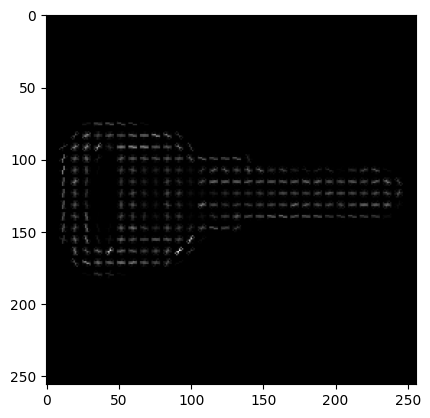

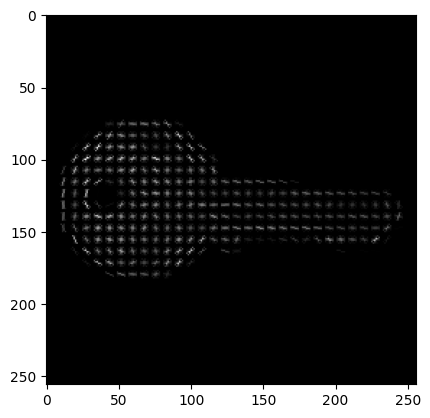

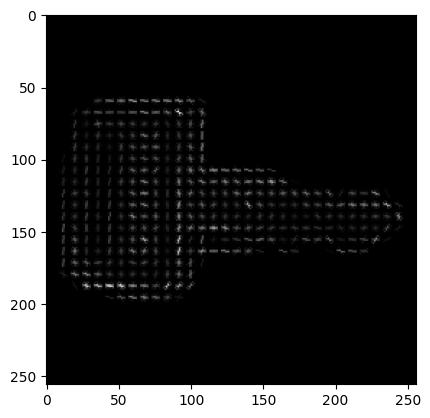

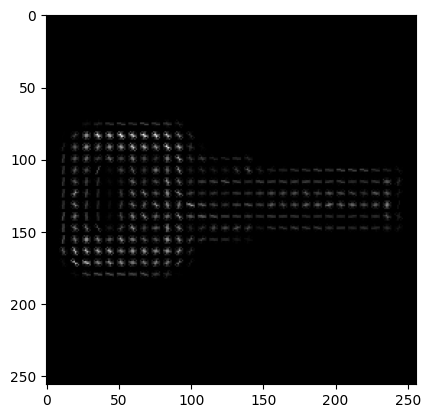

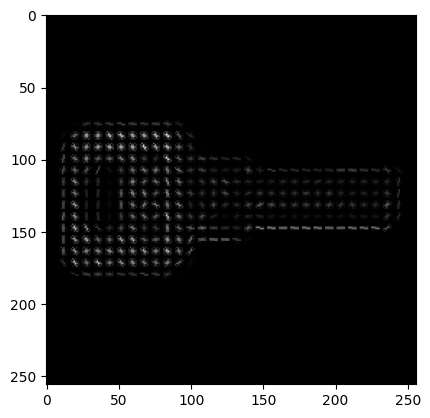

[None, None, None, None, None]

In [41]:
[plt_img(image, cmap="gray") for image in feature_images[:5]]

In [37]:
score_matrix = {}

for i, descriptor1 in enumerate(all_descriptors):
    
    row = []

    for j, descriptor2 in enumerate(all_descriptors):
        
        if i == j: continue

        score = cosine_similarity([descriptor1], [descriptor2])[0][0]

        row.append((round(score, 3), filenames[j]))
        
    row.sort(key=lambda x: x[0], reverse=True)
    score_matrix[filenames[i]] = row[:5]

i = 0
for k, v in score_matrix.items():
    print(i, k, v)
    i += 1

0 10.jpg [(0.794, '13.jpeg'), (0.782, '9.jpg'), (0.781, '14.jpeg'), (0.753, '18.jpg'), (0.742, '15.jpg')]
1 11.jpg [(0.796, '7.jpg'), (0.795, '3.jpeg'), (0.782, '13.jpeg'), (0.769, '14.jpeg'), (0.758, '12.jpeg')]
2 12.jpeg [(0.794, '16.jpg'), (0.766, '5.jpg'), (0.758, '11.jpg'), (0.748, '15.jpg'), (0.743, '17.jpg')]
3 13.jpeg [(0.9, '14.jpeg'), (0.814, '15.jpg'), (0.811, '18.jpg'), (0.794, '10.jpg'), (0.782, '11.jpg')]
4 14.jpeg [(0.9, '13.jpeg'), (0.833, '15.jpg'), (0.827, '18.jpg'), (0.793, '5.jpg'), (0.781, '10.jpg')]
5 15.jpg [(0.847, '18.jpg'), (0.833, '14.jpeg'), (0.814, '13.jpeg'), (0.81, '5.jpg'), (0.808, '16.jpg')]
6 16.jpg [(0.855, '17.jpg'), (0.808, '15.jpg'), (0.794, '12.jpeg'), (0.789, '18.jpg'), (0.781, '14.jpeg')]
7 17.jpg [(0.855, '16.jpg'), (0.773, '15.jpg'), (0.745, '18.jpg'), (0.743, '12.jpeg'), (0.728, '14.jpeg')]
8 18.jpg [(0.847, '15.jpg'), (0.827, '14.jpeg'), (0.826, '5.jpg'), (0.811, '13.jpeg'), (0.789, '16.jpg')]
9 1a.jpeg [(0.824, '1b.jpeg'), (0.663, '17.jpg')